In [28]:
# Import necessary modules
from tvb.simulator.lab import *
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from scipy.signal import welch

In [8]:
# 1. Load Structural Connectivity Matrix
# ======================================
con = connectivity.Connectivity.from_file('/Users/mac/Downloads/tvb_data/tvb_data/connectivity/connectivity_76.zip')
nregions = len(con.region_labels)
con.weights = con.weights - con.weights * np.eye(nregions)  # Remove self-connections
con.speed = np.array([sys.float_info.max])  # Neglect conduction speed
con.configure()

2024-08-19 23:36:48,335 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [29]:
# Extract region labels
region_labels = con.region_labels

# Get the labels for the specific indices
selected_regions = region_labels[[62, 40, 47, 69, 72]]

# Display the selected regions
print("Selected brain regions:", selected_regions)

Selected brain regions: ['lPHC' 'lAMYG' 'lHC' 'lTCI' 'lTCV']


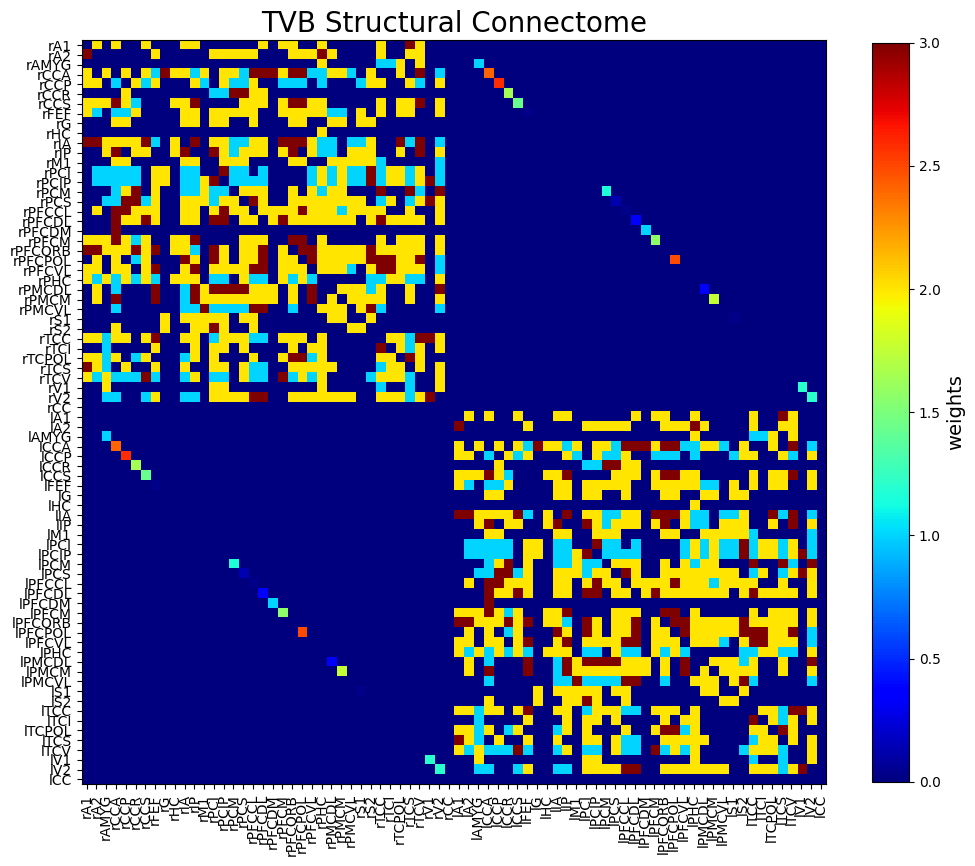

In [9]:
# 2. Visualize the Structural Connectome
# ======================================
plt.figure(figsize=(12,12))
plt.imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), con.region_labels, fontsize=10, rotation=90)
plt.yticks(range(0, nregions), con.region_labels, fontsize=10)
cb = plt.colorbar(shrink=0.8)
cb.set_label('weights', fontsize=14)
plt.show()


In [10]:
# 3. Initialize the Hybrid Epileptor Model
# ========================================
mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
mod.a_rs = np.ones((nregions)) * (1.7402)

# Define Epileptogenic Network (EZ, PZ, NIZ)
mod.x0 = np.ones((nregions)) * (-2.3)  # NIZ
mod.x0[[40]] = np.ones((1)) * (-1.4)   # EZ: lAMYG
mod.x0[[47, 62]] = np.ones((2)) * (-1.6)  # EZ: lHC, lPHC
mod.x0[[69]] = np.ones((1)) * (-1.7)   # PZ: lTCI
mod.x0[[72]] = np.ones((1)) * (-1.8)   # PZ: lTCV

mod.bb = np.ones((nregions)) * (4)     # NIZ
mod.bb[[40, 47, 62]] = np.ones((3)) * (1)  # EZ
mod.bb[[69, 72]] = np.ones((2)) * (2)  # PZ

mod.p = np.ones((nregions)) * (0.1)    # NIZ
mod.p[[40, 47, 62]] = np.ones((3)) * (0.9)  # EZ
mod.p[[69, 72]] = np.ones((2)) * (0.7)  # PZ


In [11]:
# 4. Set up the Coupling Function
# ===============================
coupl = 1
con_coupling = coupling.Difference(a=np.array([coupl]))

In [12]:
# 5. Initialize the Integrator (with Noise)
# =========================================
dt = 0.1  # Integration step size [ms]
nsigma1 = 0.00025  # Noise standard deviation for x2 and y2
nsigma2 = 0.001  # Noise standard deviation for x_rs

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma1, nsigma1, 0., nsigma2, 0.]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

In [18]:
# 6. Define Monitors
# ==================
mon_tavg = monitors.TemporalAverage(period=1)  # Monitor with 1ms period
what_to_watch = mon_tavg

In [19]:
# 7. Set up the Simulator
# =======================
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float64(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()

# 8. Run the Simulation
# =====================
simulation_length = 60000  # Simulation length in ms
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=simulation_length):
    if tavg is not None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])

print(f'Simulation required {tm.time()-tic:.3f} seconds.')


/var/folders/v7/dbllwbmn3qv0sk0spbzgpd440000gn/T/ipykernel_55414/2545637122.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conduction_speed=np.float64(con.speed),


Simulation required 106.486 seconds.


In [22]:
# 9. Process and Visualize Simulation Results
# ===========================================
tavg_data = np.squeeze(np.array(tavg_data))
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Compute LFP output model
DATA = mod.p[[0]] * tavg_data[:, 0, :] + (1 - mod.p[[0]]) * tavg_data[:, 2, :]

EZs = [62, 47, 40]
PZs = [69, 72]
for ie, ez in enumerate(EZs):
    DATA[:, EZs[ie]] = mod.p[[EZs[ie]]] * tavg_data[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * tavg_data[:, 2, EZs[ie]]
for ip, pz in enumerate(PZs):
    DATA[:, PZs[ip]] = mod.p[[PZs[ip]]] * tavg_data[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * tavg_data[:, 2, PZs[ip]]


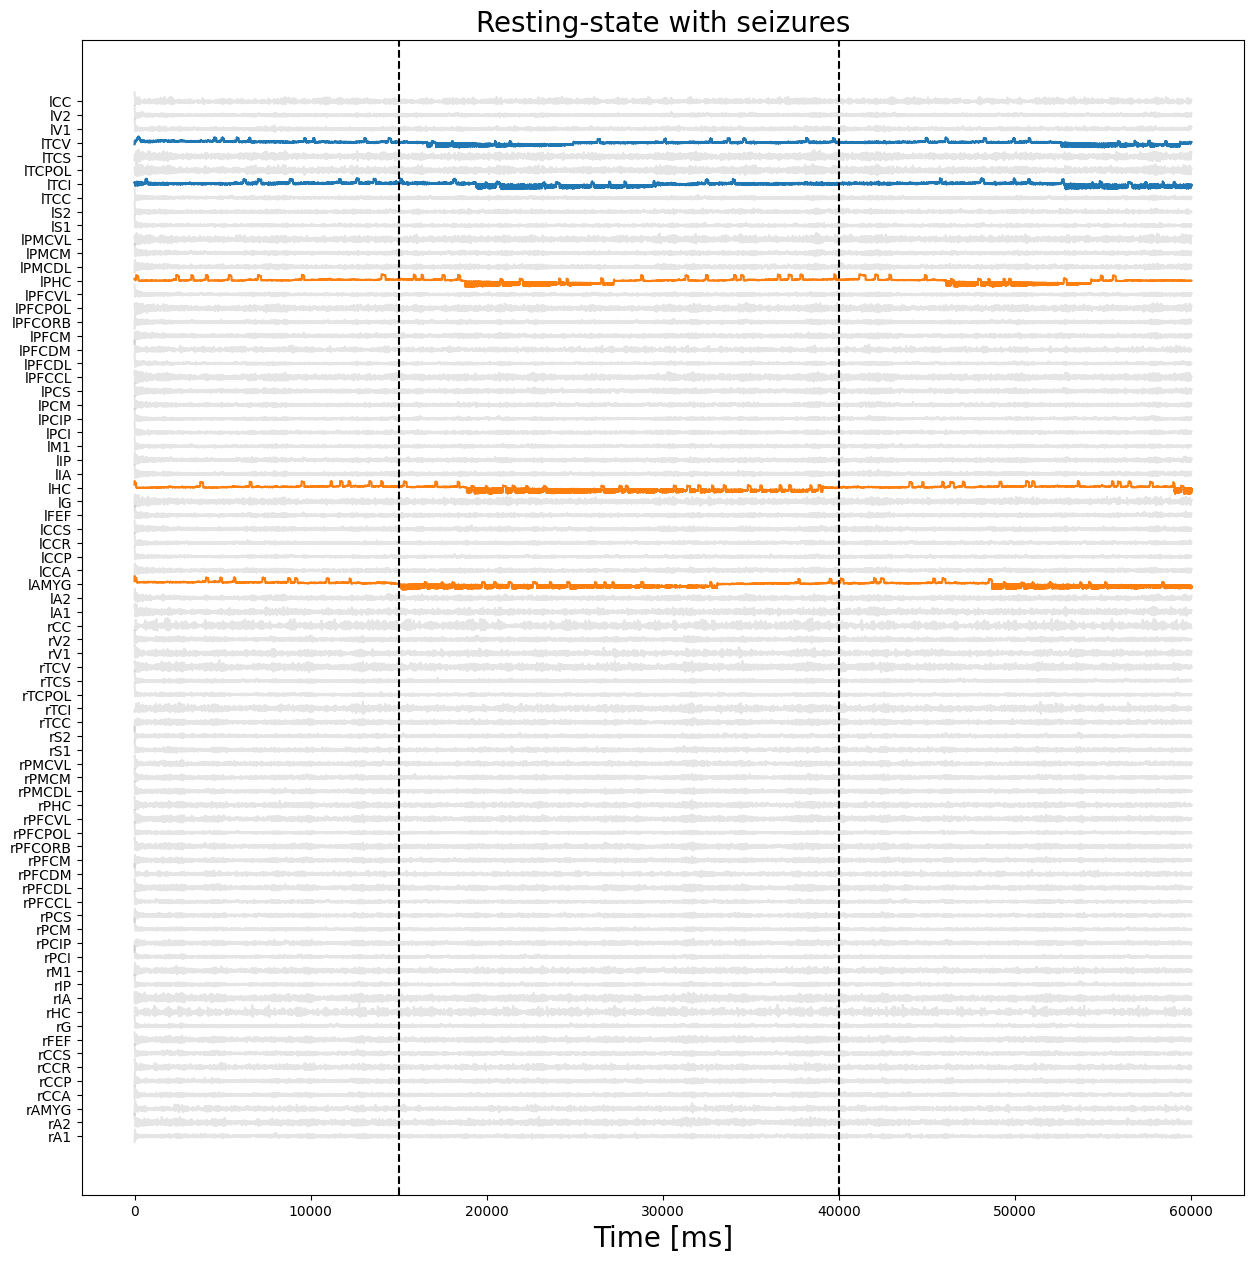

In [23]:
# Plot time series
plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + np.r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
for ip, pz in enumerate(PZs):
    plt.plot(DATA[:, PZs[ip]] + PZs[ip], 'C0')

plt.axvline(x=15000, color='k', linestyle='--')
plt.axvline(x=40000, color='k', linestyle='--')
plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.show()

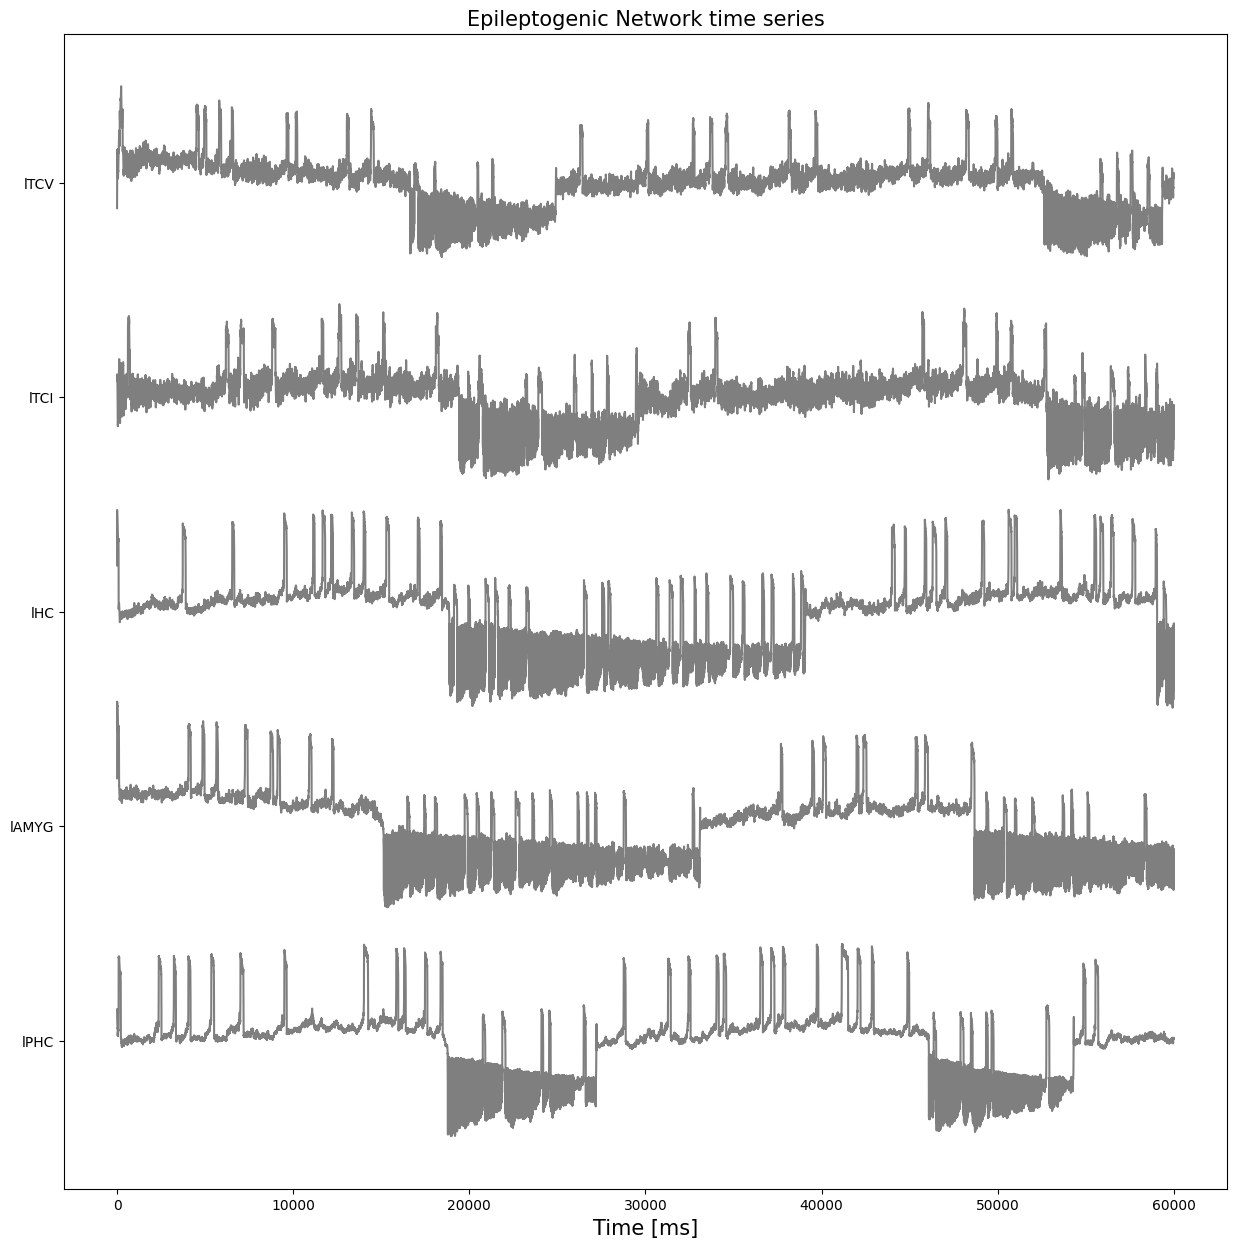

In [26]:
# Zoom in on Epileptogenic Network time series
EN = [62, 40, 47, 69, 72]
plt.figure(figsize=(15,15))
for ie, en in enumerate(EN):
    plt.plot(np.arange(0, 60000), DATA[0:60000, EN[ie]] + ie, 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])
plt.show()

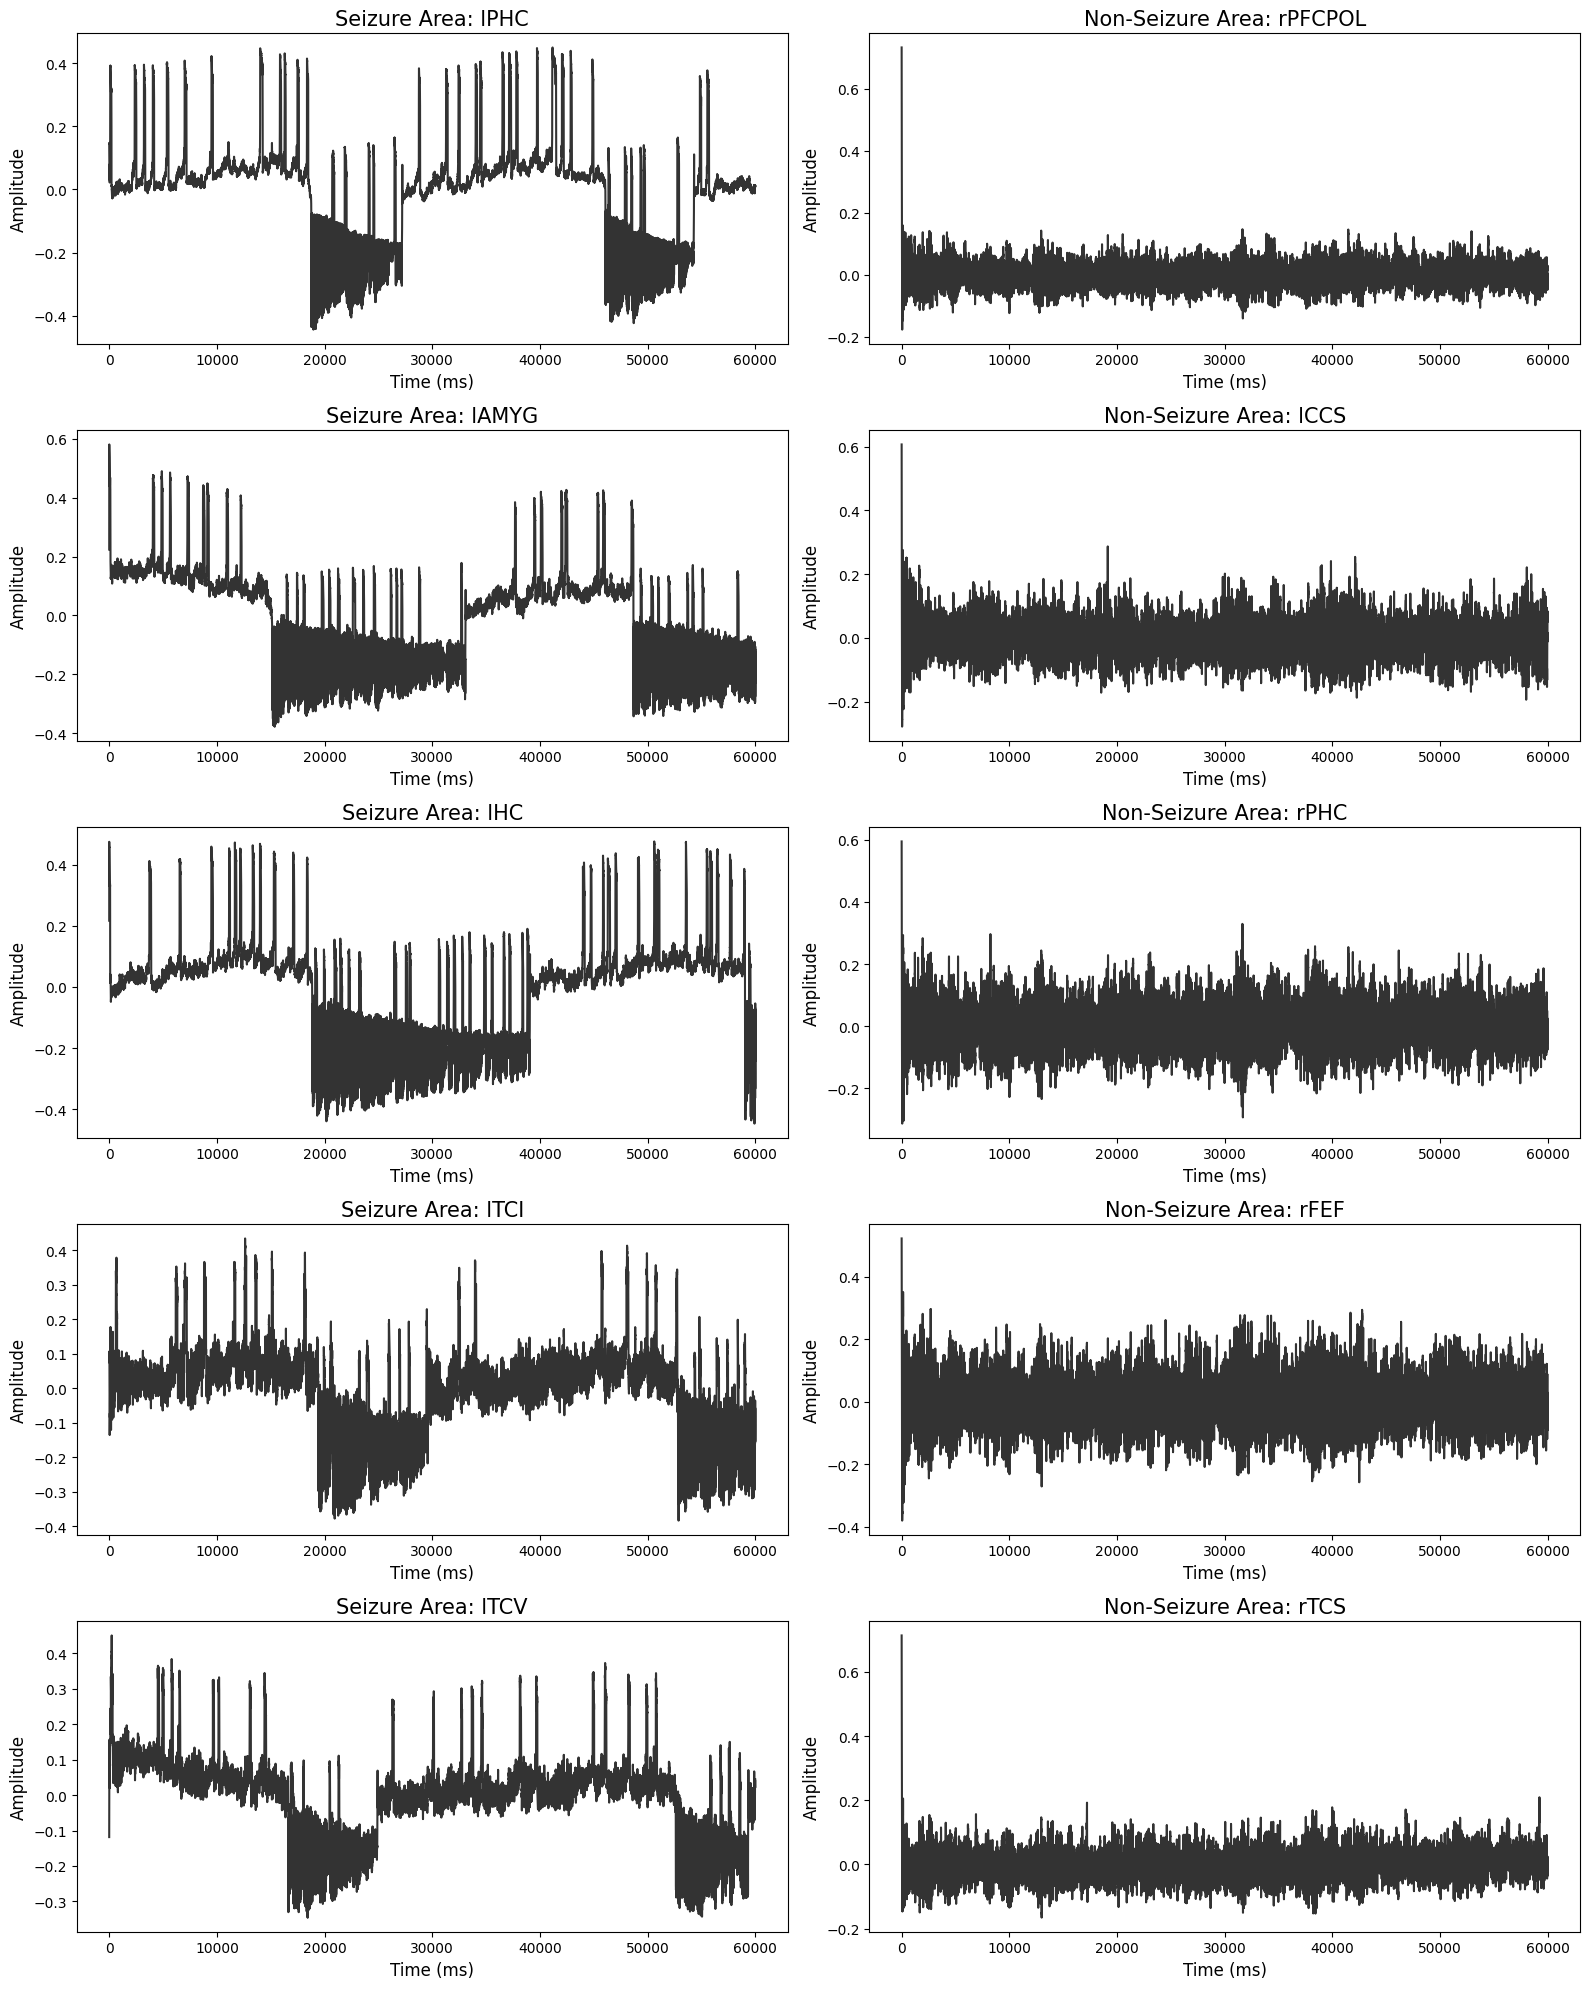

In [54]:
# List of selected seizure regions
seizure_regions = [62, 40, 47, 69, 72]

# Generate 5 random non-seizure regions that are not in the seizure list
all_regions = list(range(nregions))
non_seizure_regions = np.random.choice([r for r in all_regions if r not in seizure_regions], 5, replace=False)

# Create a figure with 2 columns and 5 rows
fig, axs = plt.subplots(5, 2, figsize=(16, 20))

# Plot each seizure region on the left side
for i, region_idx in enumerate(seizure_regions):
    axs[i, 0].plot(DATA[:, region_idx], 'k', alpha=0.8)
    axs[i, 0].set_title(f'Seizure Area: {con.region_labels[region_idx]}', fontsize=15)
    axs[i, 0].set_xlabel('Time (ms)', fontsize=12)
    axs[i, 0].set_ylabel('Amplitude', fontsize=12)

# Plot each non-seizure region on the right side
for i, region_idx in enumerate(non_seizure_regions):
    axs[i, 1].plot(DATA[:, region_idx], 'k', alpha=0.8)
    axs[i, 1].set_title(f'Non-Seizure Area: {con.region_labels[region_idx]}', fontsize=15)
    axs[i, 1].set_xlabel('Time (ms)', fontsize=12)
    axs[i, 1].set_ylabel('Amplitude', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

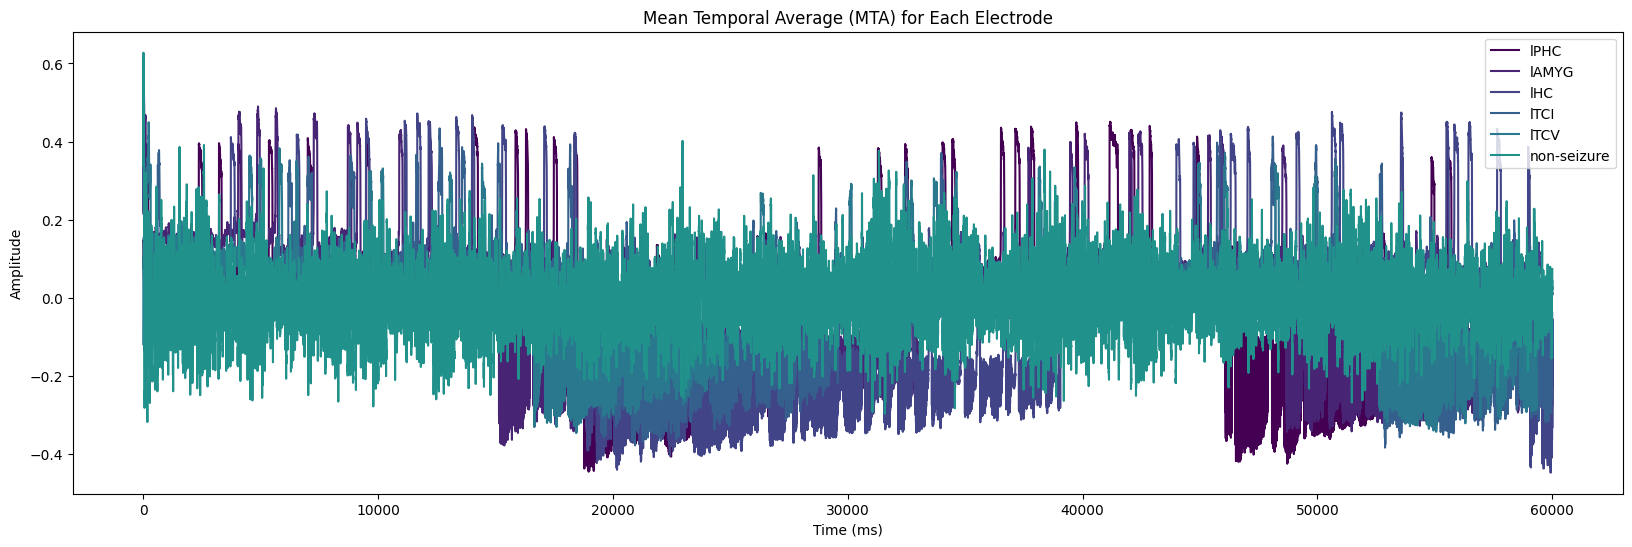

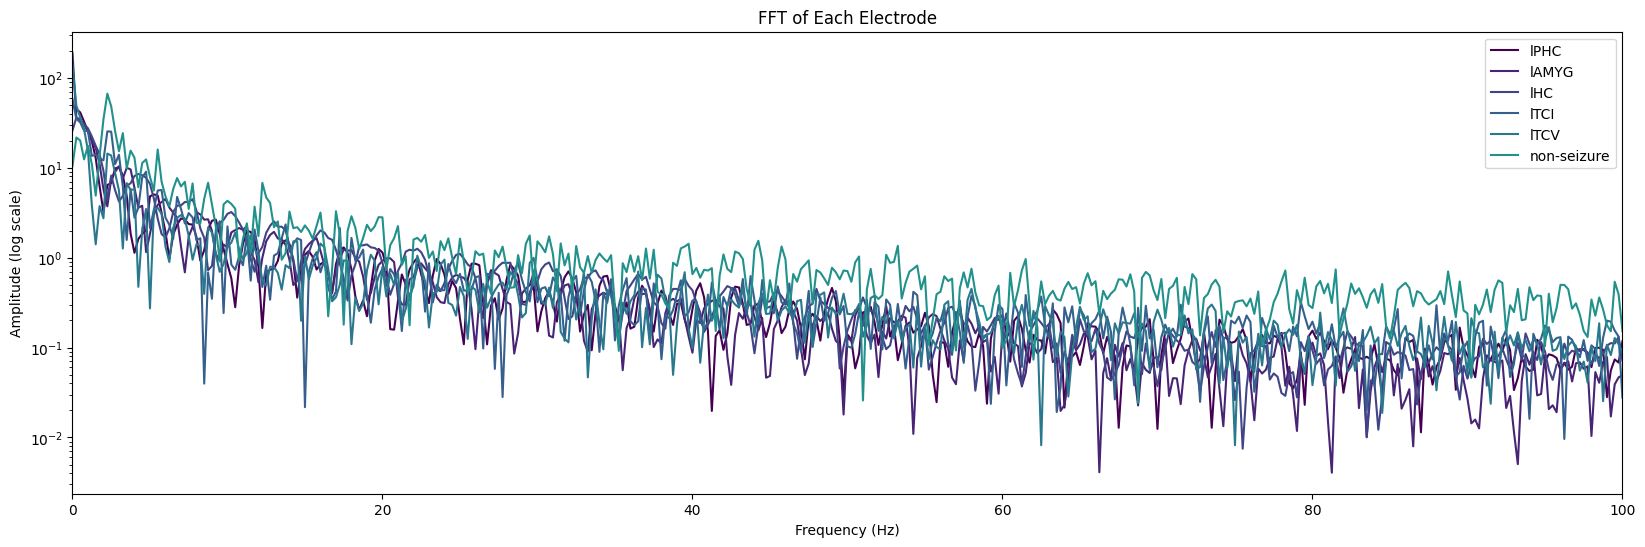

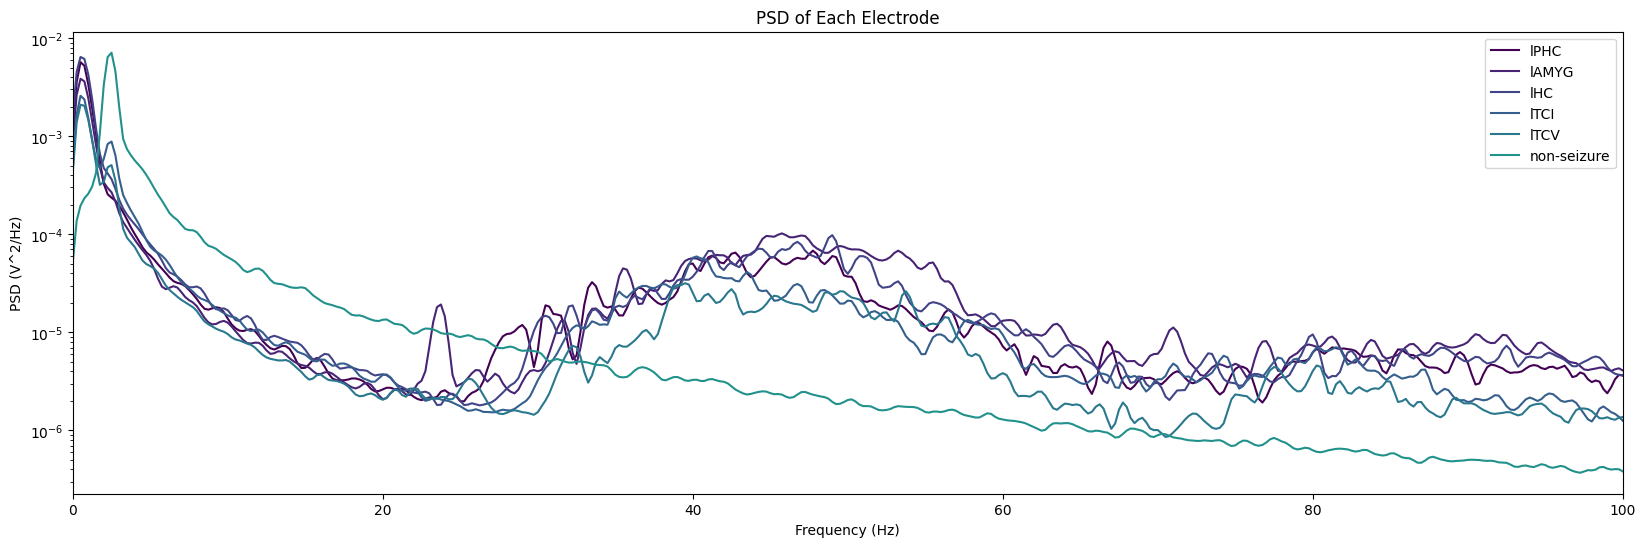

In [53]:
# Define the electrodes and their corresponding names
EN = [62, 40, 47, 69, 72, 1]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV', 'non-seizure']
colors = plt.cm.viridis(np.linspace(0, .5, len(EN)))  # Use a colormap to generate distinct colors

# Plot Mean Temporal Average
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]
    plt.plot(np.arange(0, len(electrode_data)), electrode_data, color=color, label=name)

plt.title('Mean Temporal Average (MTA) for Each Electrode')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot FFT
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(electrode_data, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)

    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]

    # Plot FFT of Mean Temporal Average
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), color=color, label=name)

plt.title('FFT of Each Electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log scale)')
plt.yscale('log')  # Use logarithmic scale for amplitude
plt.xlim(0, 100)
plt.legend()
plt.show()

# Plot PSD
plt.figure(figsize=(20, 6))
for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(electrode_data, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)

    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]

    # Plot PSD of Mean Temporal Average
    plt.semilogy(freqs, psd, color=color, label=name)

plt.title('PSD of Each Electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim(0, 100)
plt.legend()
plt.show()

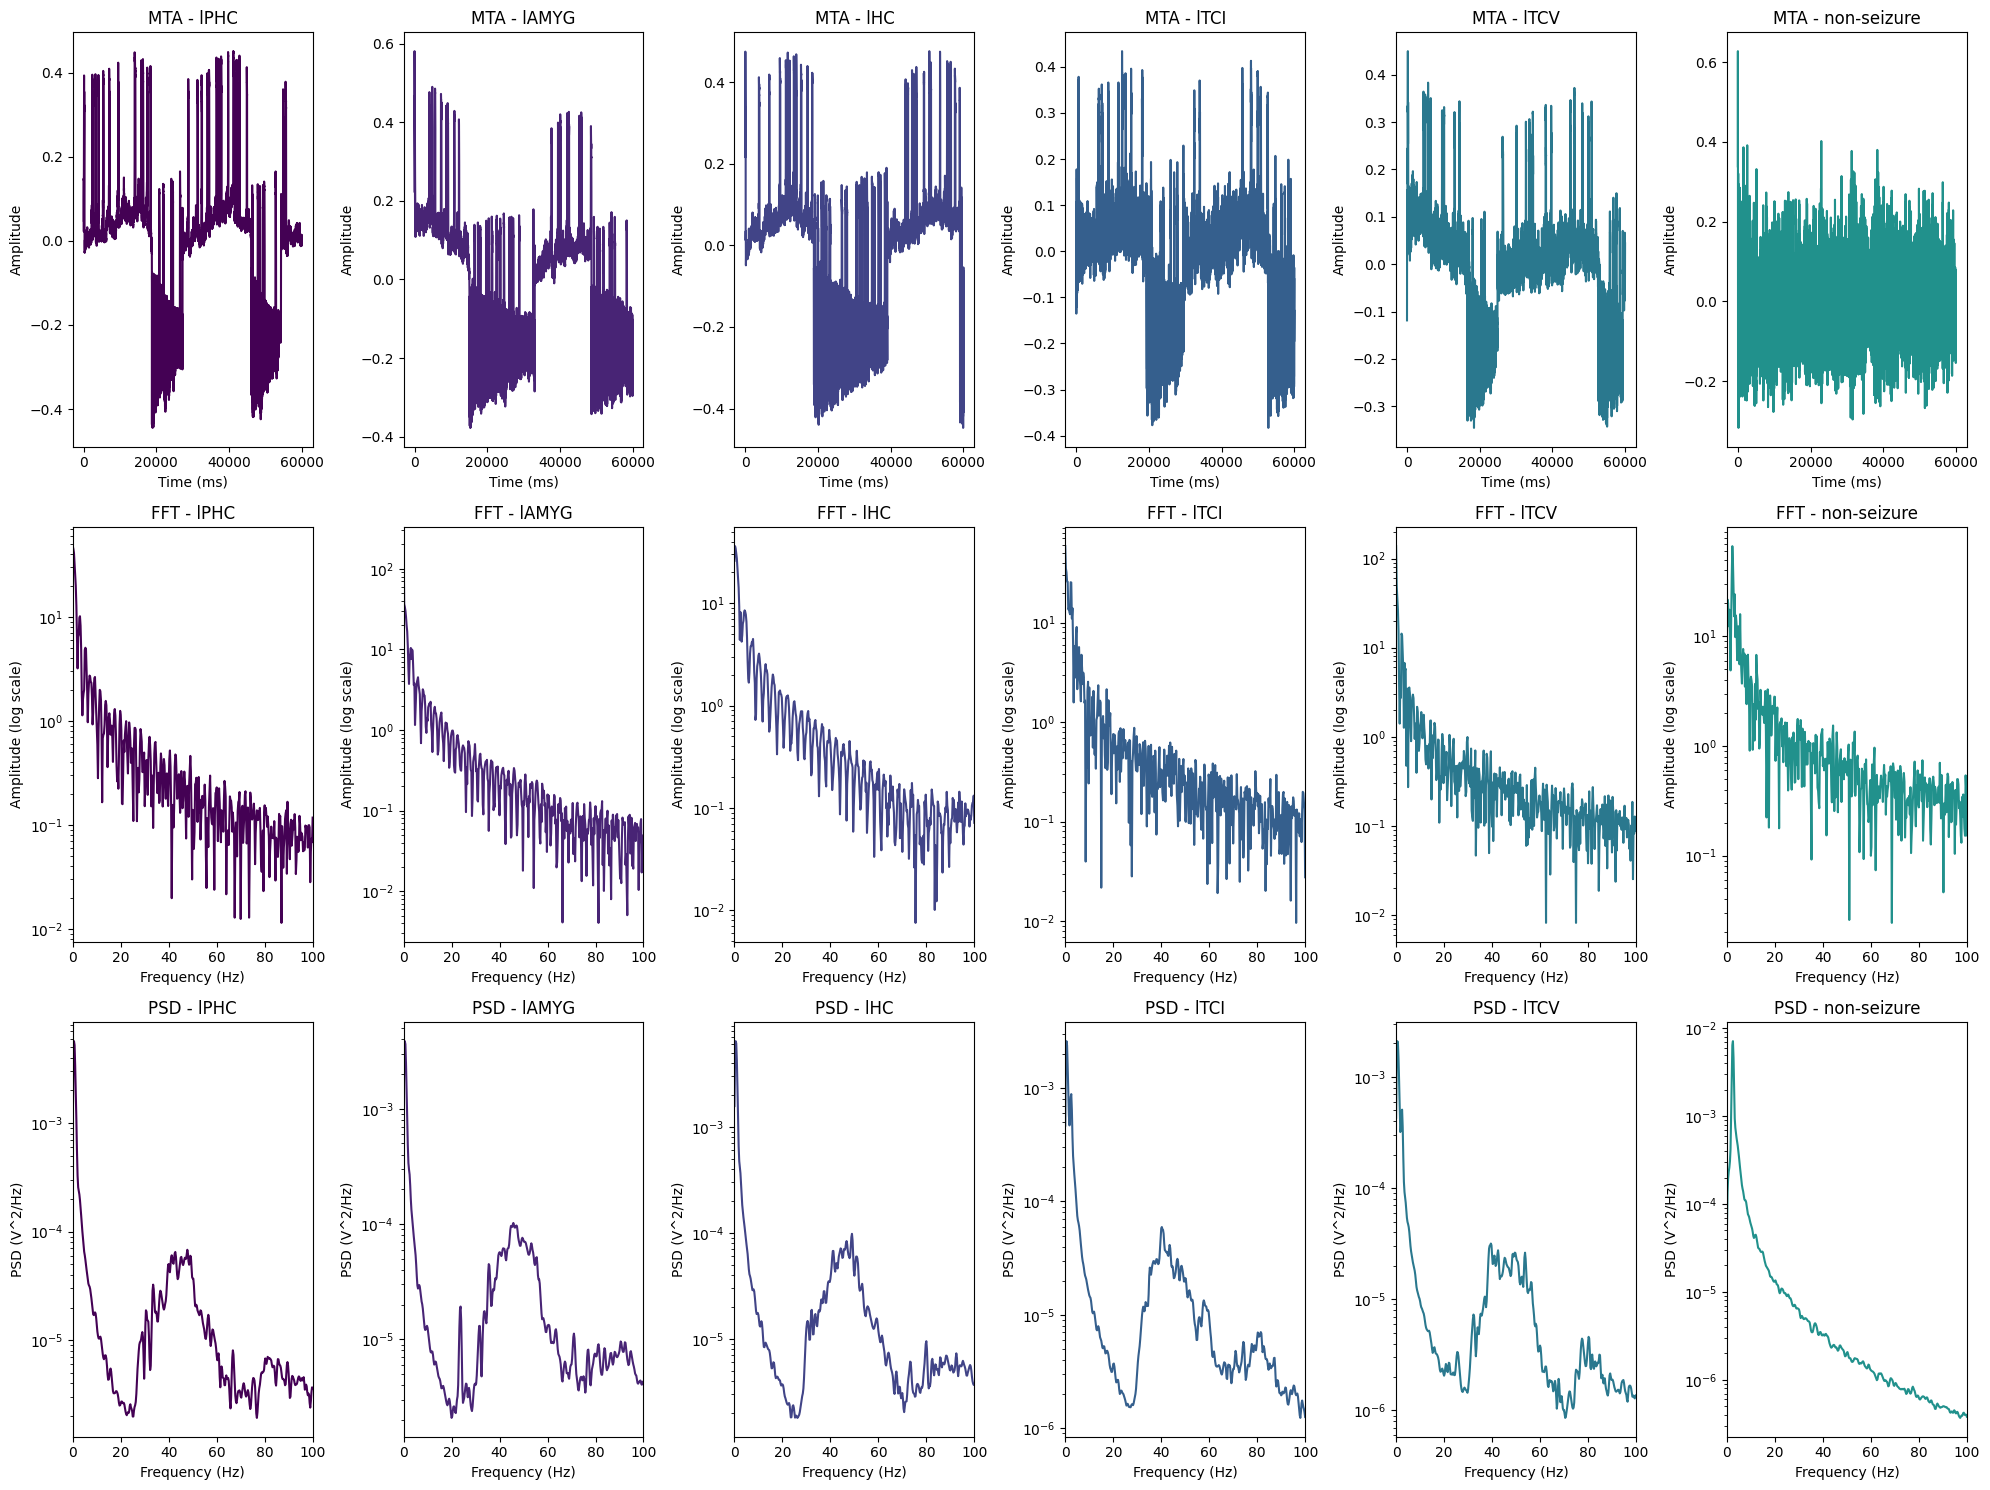

In [52]:
EN = [62, 40, 47, 69, 72, 1]
names = ['lPHC', 'lAMYG', 'lHC', 'lTCI', 'lTCV', 'non-seizure']
colors = plt.cm.viridis(np.linspace(0, .5, len(EN)))  # Use a colormap to generate distinct colors

plt.figure(figsize=(20, 15))

for idx, (en, name, color) in enumerate(zip(EN, names, colors)):
    # Extract the data for the current electrode
    electrode_data = DATA[:, en]

    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(electrode_data, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)

    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]

    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(electrode_data, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)

    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]

    # Plot Mean Temporal Average
    plt.subplot(3, len(EN), idx + 1)
    plt.plot(np.arange(0, len(electrode_data)), electrode_data, color=color)
    plt.title(f'MTA - {name}')
    plt.ylabel("Amplitude")
    plt.xlabel('Time (ms)')
  
    # Plot FFT of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, len(EN), len(EN) + idx + 1)
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), color=color)
    plt.yscale('log')  # Use logarithmic scale for amplitude
    plt.xlim(0, 100)
    plt.title(f'FFT - {name}')
    plt.ylabel('Amplitude (log scale)')
    plt.xlabel('Frequency (Hz)')

    # Plot PSD of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, len(EN), 2 * len(EN) + idx + 1)
    plt.semilogy(freqs, psd, color=color)
    plt.title(f'PSD - {name}')
    plt.xlim(0, 100)
    plt.ylabel('PSD (V^2/Hz)')
    plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [36]:
# 10. Interactive Tool for Time Series Visualization
# ==================================================
import ipywidgets as widgets
from IPython.display import display

# Define the interactive plot function
def plot_time_series(region_idx):
    plt.figure(figsize=(12, 6))
    
    # Extract data for the selected region
    region_data = DATA[:, region_idx]
    
    # Plot the time series
    plt.plot(region_data, 'k', alpha=0.8)
    plt.title(f'Time Series Data for {con.region_labels[region_idx]}', fontsize=15)
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.show()

# Define the interactive widget
region_selector = widgets.IntSlider(min=0, max=nregions-1, step=1, value=0, description='Region:')
widgets.interact(plot_time_series, region_idx=region_selector)

# Display the interactive widget
display(region_selector)


interactive(children=(IntSlider(value=0, description='Region:', max=75), Output()), _dom_classes=('widget-inte…

IntSlider(value=0, description='Region:', max=75)